In [33]:
pip install pandas yfinance matplotlib seaborn notebook


[notice] A new release of pip is available: 24.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [34]:
# Step 1: Import Libraries
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns


In [35]:
#Download Historical Data
ticker = "NVDA"  # NVIDIA
start_date = "2015-01-01"
end_date = "2024-12-31"

df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
df.head()

#This data shows the adjusted stock prices, 
#which have been historically adjusted downward
#We are using historical data because this project uses backtesting to see how
#this stock would have preformed in the past


[*********************100%***********************]  1 of 1 completed


Price          Close      High       Low      Open     Volume
Ticker          NVDA      NVDA      NVDA      NVDA       NVDA
Date                                                         
2015-01-02  0.483066  0.486665  0.475386  0.483066  113680000
2015-01-05  0.474907  0.484505  0.472747  0.483066  197952000
2015-01-06  0.460508  0.476106  0.460028  0.475626  197764000
2015-01-07  0.459308  0.467947  0.457868  0.463868  321808000
2015-01-08  0.476586  0.479466  0.464348  0.464588  283780000

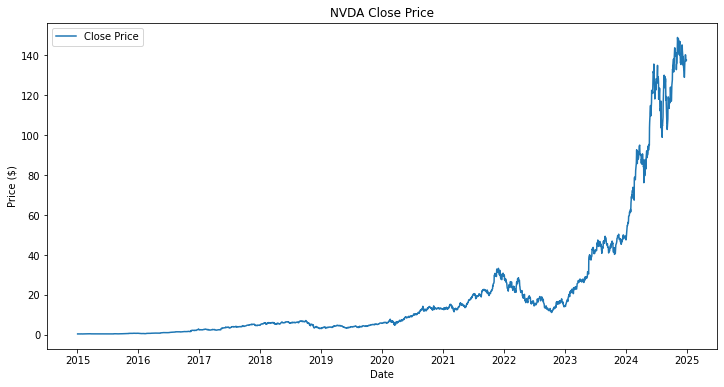

In [36]:
df.head()
df.isnull().sum()

plt.figure(figsize=(12,6))
plt.plot(df["Close"], label="Close Price")
plt.title(f"{ticker} Close Price")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

In [37]:
# Calculates the averages of the last 50 days for each closing price
df['MA_50'] = df['Close'].rolling(window=50).mean() 
# this is long term
df['MA_200'] = df['Close'].rolling(window=200).mean()
# this is short term

#When these two averages cross over, it signals a change in the trend
#A short term MA crossing ABOVE a long term MA means its time to BUY
#A short term MA crossing BELOW a long term MA means its time to SELL

# Check the last few rows
df[['Close', 'MA_50', 'MA_200']].tail()


Price            Close       MA_50      MA_200
Ticker            NVDA                        
Date                                          
2024-12-23  139.647446  139.688259  116.606688
2024-12-24  140.197372  139.731442  116.878975
2024-12-26  139.907410  139.898196  117.119130
2024-12-27  136.987885  139.924179  117.349810
2024-12-30  137.467804  139.935566  117.597604

In [38]:
# Initialize Signal column
df['Signal'] = 0

# Set Signal to 1 when short-term MA > long-term MA because its time to INVEST
df.loc[df['MA_50'] > df['MA_200'], 'Signal'] = 1

# Optional: Fill any NaNs (not strictly needed here but safe)
df['Signal'] = df['Signal'].fillna(0)

#This sets the rule to signal when to buy and when not to buy 

In [39]:
# Position: 1 = in the market, 0 = out
df['Position'] = df['Signal'].shift(1)  # Shift signal so we buy *next* day
df['Position'] = df['Position'].fillna(0)


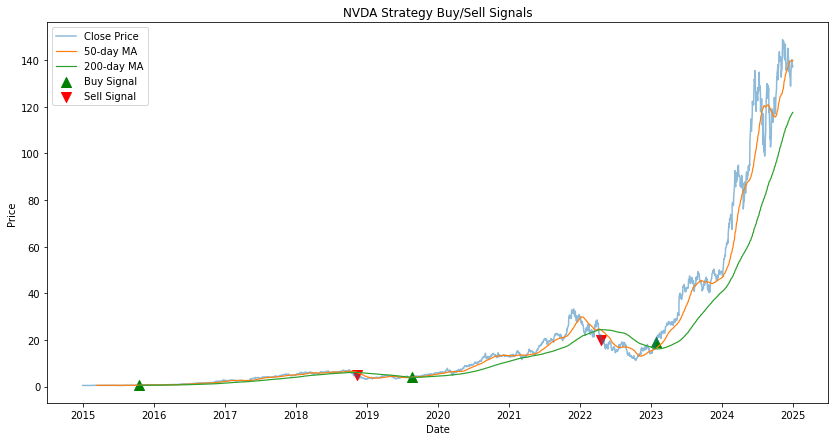

In [40]:
plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Price', alpha=0.5)
plt.plot(df['MA_50'], label='50-day MA', linewidth=1.2)
plt.plot(df['MA_200'], label='200-day MA', linewidth=1.2)

# Plot buy signals
buy_signals = df[(df['Position'] == 1) & (df['Position'].shift(1) == 0)]
plt.scatter(buy_signals.index, df.loc[buy_signals.index]['Close'], marker='^', color='green', label='Buy Signal', s=100)

# Plot sell signals
sell_signals = df[(df['Position'] == 0) & (df['Position'].shift(1) == 1)]
plt.scatter(sell_signals.index, df.loc[sell_signals.index]['Close'], marker='v', color='red', label='Sell Signal', s=100)

plt.title(f'{ticker} Strategy Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [41]:
# Daily returns from closing prices
df['Daily_Return'] = df['Close'].pct_change()
df['Daily_Return']
#Shows how volatile a stock is day to day 

Date
2015-01-02         NaN
2015-01-05   -0.016890
2015-01-06   -0.030318
2015-01-07   -0.002606
2015-01-08    0.037617
                ...   
2024-12-23    0.036897
2024-12-24    0.003938
2024-12-26   -0.002068
2024-12-27   -0.020868
2024-12-30    0.003503
Name: Daily_Return, Length: 2515, dtype: float64

In [42]:
# Strategy returns = return only when you're in the market
df['Strategy_Return'] = df['Daily_Return'] * df['Position']
df['Strategy_Return']
#shows how well your signals translate to profit and compare when you're 
#active vs passive income
#Your return on a given day only if you were holding the stock, based on your strategy

Date
2015-01-02         NaN
2015-01-05   -0.000000
2015-01-06   -0.000000
2015-01-07   -0.000000
2015-01-08    0.000000
                ...   
2024-12-23    0.036897
2024-12-24    0.003938
2024-12-26   -0.002068
2024-12-27   -0.020868
2024-12-30    0.003503
Name: Strategy_Return, Length: 2515, dtype: float64

In [43]:
df['Cumulative_Market_Returns'] = (1 + df['Daily_Return']).cumprod()
df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Return']).cumprod()

#This is the Equity curve - how the portfolio grows
#you're growth over time if you reinvest
#is this strategy worth holding?

In [44]:
df['Cumulative_Strategy_Returns']

Date
2015-01-02           NaN
2015-01-05      1.000000
2015-01-06      1.000000
2015-01-07      1.000000
2015-01-08      1.000000
                 ...    
2024-12-23    266.258773
2024-12-24    267.307291
2024-12-26    266.754433
2024-12-27    261.187921
2024-12-30    262.102959
Name: Cumulative_Strategy_Returns, Length: 2515, dtype: float64

In [45]:
df['Cumulative_Market_Returns']

Date
2015-01-02           NaN
2015-01-05      0.983110
2015-01-06      0.953303
2015-01-07      0.950820
2015-01-08      0.986587
                 ...    
2024-12-23    289.085898
2024-12-24    290.224308
2024-12-26    289.624053
2024-12-27    283.580308
2024-12-30    284.573795
Name: Cumulative_Market_Returns, Length: 2515, dtype: float64

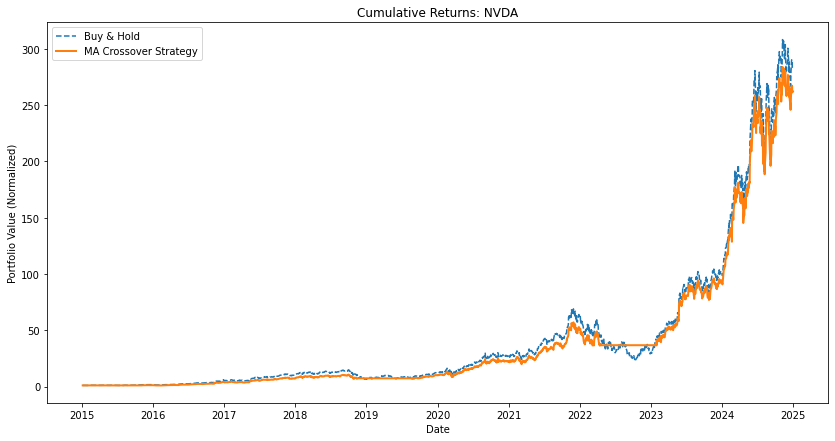

In [46]:
plt.figure(figsize=(14, 7))
plt.plot(df['Cumulative_Market_Returns'], label='Buy & Hold', linestyle='--')
plt.plot(df['Cumulative_Strategy_Returns'], label='MA Crossover Strategy', linewidth=2)
plt.title(f'Cumulative Returns: {ticker}')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Normalized)')
plt.legend()
plt.show()


In [47]:
# Total Return
total_strategy_return = df['Cumulative_Strategy_Returns'].iloc[-1] - 1
total_market_return = df['Cumulative_Market_Returns'].iloc[-1] - 1

print(f"Strategy Total Return: {total_strategy_return:.2%}")
print(f"Market Total Return: {total_market_return:.2%}")


Strategy Total Return: 26110.30%
Market Total Return: 28357.38%


In [48]:
strategy_returns = df['Strategy_Return'].dropna()
market_returns = df['Daily_Return'].dropna()

sharpe_strategy = (strategy_returns.mean() / strategy_returns.std()) * (252 ** 0.5)
sharpe_market = (market_returns.mean() / market_returns.std()) * (252 ** 0.5)

print(f"Sharpe Ratio (Strategy): {sharpe_strategy:.2f}")
print(f"Sharpe Ratio (Market): {sharpe_market:.2f}")

#compares different strategy across difeferent risk levels
#A measure of risk-adjusted return
#It tells you how much return youâ€™re getting for each unit of risk


Sharpe Ratio (Strategy): 1.54
Sharpe Ratio (Market): 1.41
